# Исследование по теме наставничества. Часть III - Topmodeling

В предыдущем этапе мы провели исследовательский анализ полученных данных, остается финальный этап.

В данном файле будет проведено:
* выделение из текста тем, 
* определение топ-10 тем (искомые теги Наставничество, менторство, коучинг, mentorship, mentor, coaching, buddy)
* определение топ-10 популярных тем по просмотрам, реакциям: лайкам, комментариям, репостам среди IT-специалистов, 

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import string

import pandas as pd
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#from nltk.stem import WordNetLemmatizer

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('max_colwidth', 300)
pd.set_option('display.width', 480)

!python -m spacy download ru_core_news_sm
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\s7\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\s7\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                              0.0/15.3 MB ? eta -:--:--
                                              0.1/15.3 MB 1.8 MB/s eta 0:00:09
                                              0.2/15.3 MB 2.4 MB/s eta 0:00:07
     -                                        0.4/15.3 MB 2.8 MB/s eta 0:00:06
     --                                       0.8/15.3 MB 4.3 MB/s eta 0:00:04
     --                                       1.1/15.3 MB 4.8 MB/s eta 0:00:03
     ----                                     1.6/15.3 MB 5.8 MB/s eta 0:00:03
     ------                                   2.5/15.3 MB 7.5 MB/s eta 0:00:02
     ------                                   2.5/15.3 MB 7.6 MB/s eta 0:00:02
     ---------                                3.6/15.3 MB 8.4 MB/s eta 0:00:02
     ----------                               4.1/15.3 MB 8.8 MB/s eta 0:00:02
     ------------                             4.6/15.3 MB 9.0 MB/s eta 0:00:02
     -------------                            5.2/15.3 MB 9

In [3]:
df = pd.read_csv('data\data.csv', index_col='Unnamed: 0')

In [4]:
df.head(3)

,name,works_at,cur_profile_url,post,reaction,works_at_clean
0,Александр Масловский,Java Team Lead - IT_One,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5%D0%BA%D1%81%D0%B0%D0%BD%D0%B4%D1%80-%D0%BC%D0%B0%D1%81%D0%BB%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9-165873179/,NaN,1,java team lead
1,Александр Масловский,Java Team Lead - IT_One,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5%D0%BA%D1%81%D0%B0%D0%BD%D0%B4%D1%80-%D0%BC%D0%B0%D1%81%D0%BB%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9-165873179/,NaN,1,java team lead
2,Александр Масловский,Java Team Lead - IT_One,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5%D0%BA%D1%81%D0%B0%D0%BD%D0%B4%D1%80-%D0%BC%D0%B0%D1%81%D0%BB%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9-165873179/,"Правильно! Полностью поддерживаю! Мы ведь в IT живем в своем отдельном мире - так давайте собственным примером показывать остальному миру, что такое уважение, здоровое общение, дружба и профессионализм. Кто, если не мы?Женя, с наступающим!",5,java team lead


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2136 entries, 0 to 2135
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             2136 non-null   object
 1   works_at         2135 non-null   object
 2   cur_profile_url  2136 non-null   object
 3   post             727 non-null    object
 4   reaction         734 non-null    object
 5   works_at_clean   2040 non-null   object
dtypes: object(6)
memory usage: 116.8+ KB


оставляем посты и реакции

In [6]:
df = df[['post', 'reaction']]

In [7]:
df['post'].value_counts().head(20)

post
Здравствуйте, я в поиске новой карьерной возможности и буду признателен(а) за вашу поддержку. Заранее благодарю за все рекомендации контактов, советы или возможности, которые вы можете предложить. #OpenToWork                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      26
Hi everyone - I am looking for a new role and would appreciate your suppor

In [8]:
spam = [
    'I just earned a skill badge', 
    'Я только что получил(а) значок',
    'I am looking for a new role',
    'I’m happy to share that I’m starting',
    'I’m happy to share that I’ve finished',
    'С удовольствием сообщаю, что я начинаю работу',
    'С удовольствием сообщаю, что я получил(а)',
    'Здравствуйте, я в поиске новой карьерной возможности'
    ]

spam_pattern = '|'.join(map(re.escape, spam))

In [9]:
df = df.dropna()

In [10]:
df = df[~df['post'].str.contains(spam_pattern)]

In [11]:
df['post'].value_counts().head(20)

post
#it #humor #memes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [12]:
# оставим толь "reaction"
df['reaction'] = df['reaction'].str.extract('(\d+)').astype(int) + 1

In [13]:
df.sort_values(by='reaction', ascending=False).head(10)

,post,reaction
1713,"Алгоритмы LinkedIn 2023 в одной инфографикеПеревел и адаптировал под русскоязычную аудиторию данные из актуального исследования по алгоритмам LinkedInДанные в этом исследовании больше относятся к тем, кто делает контент в LinkedIn, а не только бездумно спамит в личку. Есть к вам просьба: оставит...",787
623,"It's here – the deepest, sharpest infrared view of the universe to date: Webb's First Deep Field.Previewed by President Biden on July 11, the image shows us galaxies once invisible to us. The full set of the James Webb Space Telescope's first full-color images & data will be revealed July 12: na...",535
1509,I started my career in Data Science back in 2016 ⏳ Here's a detailed roadmap for those starting out today! What's covered:- Python- Machine Learning- Maths for ML- ML Books- MLOps- LLMsA Thread 🧵👇 1️⃣ PythonIf you are new to programming and just getting started.There isn't a better place to lear...,505
197,"It's not core to TDD to test boundary conditions, failure modes, corner cases, &c. Those tests are essential, but they aren't necessary for the TDD process itself, which is mostly about incremental design, IMO. Start with one tiny test that verifies one tiny bit of correct behavior. Get it green...",407
319,It's (mostly) true,406
1377,Family Office Hunting in Saudi Arabia - Live with Obediah AytonClick the like button if you are enjoying yourself and feel free to ask any questions!!!\n\nThis is a live stream where I will show you how to find and contact Family Offices in Saudi Arabia through Linkedin\n\nYouTube Live Link: htt...,345
311,)),324
1376,"Get ready to dive into the captivating world of AI with the man who's generating a global buzz and leaving everyone wondering, 'What's next?' 🌐✨​​Are you prepared to hear his extraordinary journey, unveiling industry-defining breakthroughs, invaluable insights he's gathered, and the boundless po...",321
110,"Привет! Я по-прежнему в поиске классных QA к себе в команду 🙂Есть несколько позиций:- QA backend- QA Fullstack (fronted + backend)- QA mobileТребования все те же, что и в вакансии в моих предыдущих публикациях:- опыт тестирования от 2 лет- теоретические знания автоматизации must have, практическ...",263
1031,"Лично я отправляю в бан любой контакт, написавший пост о политике, или лайкнувший пост о политике и в следствии этого пост попал в мою ленту. Надеюсь кто -то делает также и вы поймете, что линк не для политики",257


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 2 to 2129
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   post      462 non-null    object
 1   reaction  462 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 9.0+ KB


In [15]:
df['post'].sample(3)

1118    Как и большинство из моего поколения, я родился и был воспитан людьми из многонациональной страны.Страны, которой уже нет. Несмотря на то, что я выросв России и являюсь гражданином РФ, ментально я человек Союза.Мои корни это: Грузия, Россия, Беларусь, Украина иЛитва. В каждой из этих стран я мог...
1762                                                                                  В команду требуется frontend разработчик с врожденным чувством прекрасного и идеальным глазомером, который мог бы не просто реализовать идеи наших проектировщиков и дизайнеров, но и сделать их лучше.http://lnkd.in/bWC_p3W
1526                                                                                                                                                                                                                                                                    2021, November. AI Hackathon. That was fun!
Name: post, dtype: object

In [16]:
def clean_text(text:str, ru=True):
    '''
    Функция очищает текст от лишних символов:
    - удаляет все что в квадратных скобках;
    - заменяет ссылки начинающиеся с http и www на site;
    - упоминания пользователей @ на user;
    - хэштэги # на hashtag;
    - символ "_" на пробел;
    - все что в <> на пробел;
    - пунктуацию удаляет;
    - переносы строк \n на пробел;
    - цифры прочие на пробел;
    - удаляет лишние пробелы
    
    Arguments:
    text -- str
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text) # все что в квадратных скобках
    text = re.sub(r":[^:]+:", ' ', text) # все что в : скобках
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # ссылки 
    text = re.sub(r'@\w+',' ', text) # упоминания
    text = re.sub(r'#\w+',' ', text) #hashtag
    text = re.sub(r'_\w+',' ', text) # underscore на пробел
    text = re.sub(r"'\w+",' ', text) # ' на пробел и то что после типа I'm, cann't
    text = re.sub('<.*?>+', ' ', text) # < >
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # пунктуация
    text = re.sub('\n', ' ', text) #переносы на пробел
    text = re.sub('\w*\d\w*', ' ', text) # цифры и пр
    #text = re.sub(r'[^a-z]', ' ', text) # вдруг что то осталось анг
    #text = re.sub(r'[^а-яa-z]', ' ', text) # вариант для двух

    if ru==True:
        text = re.sub(r'[^а-я]', ' ', text)# вдруг что то осталось ру
    else:
        text = re.sub(r'[^a-z]', ' ', text)# вдруг что то осталось анг
        
    text = text.replace('https', '') #linkedin
    text = text.replace('linkedin', '') #linkedin
    text = text.replace('lnkd', '') #linkedin
    text = re.sub(r"^\s+", "", text) # пробел в начале
    text = re.sub(r"\s+$", "", text) # пробел в конце
    text = re.sub(" +", " ", text) # пробелы

    
    
    return text

Разделим столбцы по используемому языку в сообщении, анализировать каждый будем отдельно

In [17]:
df['post_clean_ru'] = df['post'].apply(lambda x: clean_text(x))
df['post_clean_en'] = df['post'].apply(lambda x: clean_text(x, ru=False))
df.head(3)

,post,reaction,post_clean_ru,post_clean_en
2,"Правильно! Полностью поддерживаю! Мы ведь в IT живем в своем отдельном мире - так давайте собственным примером показывать остальному миру, что такое уважение, здоровое общение, дружба и профессионализм. Кто, если не мы?Женя, с наступающим!",6,правильно полностью поддерживаю мы ведь в живем в своем отдельном мире так давайте собственным примером показывать остальному миру что такое уважение здоровое общение дружба и профессионализм кто если не мы женя с наступающим,it
6,"Hey, Hey!There is an experienced BI analyst and new-made Aliyah from Russia!🤘",3,,hey hey there is an experienced bi analyst and new made aliyah from russia
10,#inspiration #philips,3,,


In [18]:
# рефакторинг кода в функцию?

disabled_pipes = [ "parser",  "ner"]
nlp_ru = spacy.load('ru_core_news_sm', disable=disabled_pipes)
nlp_en = spacy.load('en_core_web_sm', disable=disabled_pipes)

df['post_clean_ru'] = df['post_clean_ru'].apply(lambda x: x.split(' '))
df['post_clean_en'] = df['post_clean_en'].apply(lambda x: x.split(' '))

# удаляем стоп слова
stop_words_en = stopwords.words('english')
stop_words_ru = stopwords.words('russian')
df['post_clean_ru'] = df['post_clean_ru'].apply(lambda words: [word for word in words if not word in stop_words_ru])
df['post_clean_en'] = df['post_clean_en'].apply(lambda words: [word for word in words if not word in stop_words_en])

# лематизируем
df['post_clean_ru'] = df['post_clean_ru'].apply(lambda words: [word.lemma_ for word in nlp_ru(' '.join(words))])
df['post_clean_en'] = df['post_clean_en'].apply(lambda words: [word.lemma_ for word in nlp_en(' '.join(words))])
df['post_clean_ru'] = df['post_clean_ru'].apply(lambda x: ' '.join(x))
df['post_clean_en'] = df['post_clean_en'].apply(lambda x: ' '.join(x))

# добавим столбец с длинной текста
df['len_post_en'] = df['post_clean_en'].apply(lambda x: len(x))
df['len_post_ru'] = df['post_clean_ru'].apply(lambda x: len(x))
df['total_len_post'] = df['len_post_en'] + df['len_post_ru']

# короткие фразы уберем
df.loc[df['len_post_en'] < 20, 'post_clean_en'] = ''
df.loc[df['len_post_ru'] < 20, 'post_clean_ru'] = ''

In [19]:
df.head()

,post,reaction,post_clean_ru,post_clean_en,len_post_en,len_post_ru,total_len_post
2,"Правильно! Полностью поддерживаю! Мы ведь в IT живем в своем отдельном мире - так давайте собственным примером показывать остальному миру, что такое уважение, здоровое общение, дружба и профессионализм. Кто, если не мы?Женя, с наступающим!",6,правильно полностью поддерживать жить свой отдельный мир давать собственный пример показывать остальному мир такой уважение здоровый общение дружба профессионализм женя наступать,,0,178,178
6,"Hey, Hey!There is an experienced BI analyst and new-made Aliyah from Russia!🤘",3,,hey hey experienced bi analyst new make aliyah russia,53,0,53
10,#inspiration #philips,3,,,0,0,0
17,"✅‼️Web Development by GOOGLE- FREE COURSES ( ENG+RU )✅‼️Like and repost it so that as many people as possible can find out about this cool opportunity!I am open to new acquaintances, add me to your network Поставь лайк и сделай репост, что бы как можно больше людей узнали о такой крутой возможн...",61,поставь лайк сделай репост человек узнать крутой возможность открыть новый знакомство быть рад добавите сеть контакт,web development google free course eng ru like repost many people possible find cool opportunity open new acquaintance add network website web application app website firebase dxvnmyafsecure rate limit api call api gateway website google cloud,243,116,359
22,*Dancing*,25,,,5,0,5


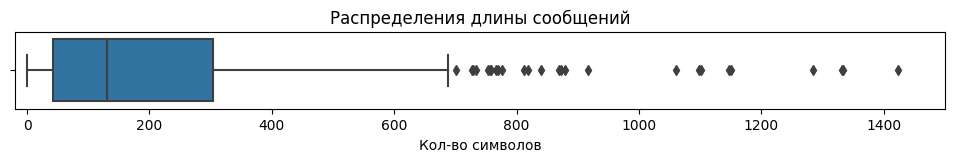

In [20]:
plt.figure(figsize=(12,1))
plt.title('Распределения длины сообщений')
sns.boxplot(x = "total_len_post", data=df, orient='h')
plt.xlabel('Кол-во символов')
plt.xlim(-20, 1500);

Посмотрим на самые популярные слова в корпусе текстов отдельно для русского и английского языка

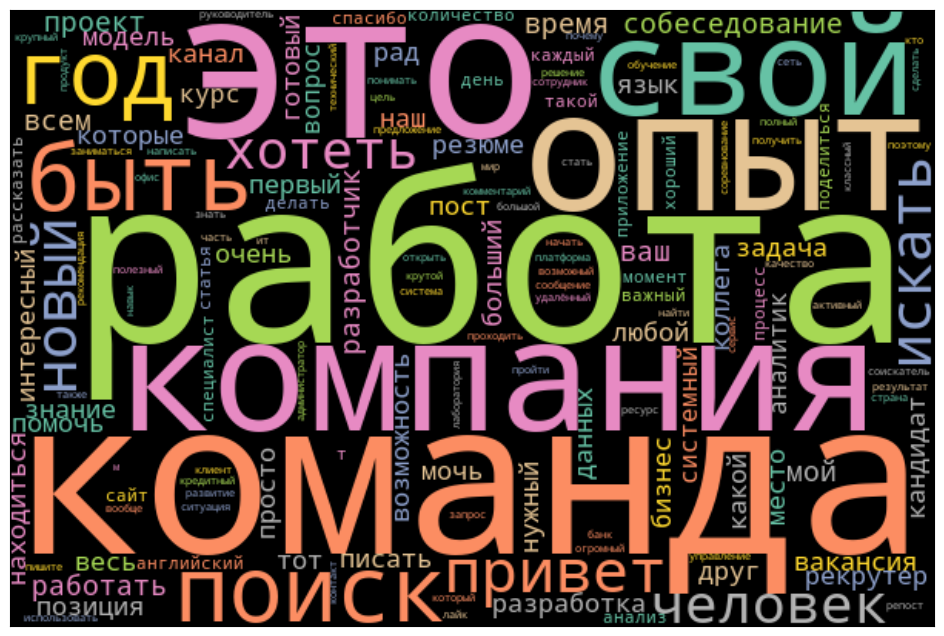

In [21]:
plt.figure(figsize=(12,8))
text = ' '.join(df['post_clean_ru'])
WC = WordCloud(width=600, 
               height=400, 
               max_words=150, 
               min_font_size=5,
               colormap='Set2', 
               collocations=False)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show;

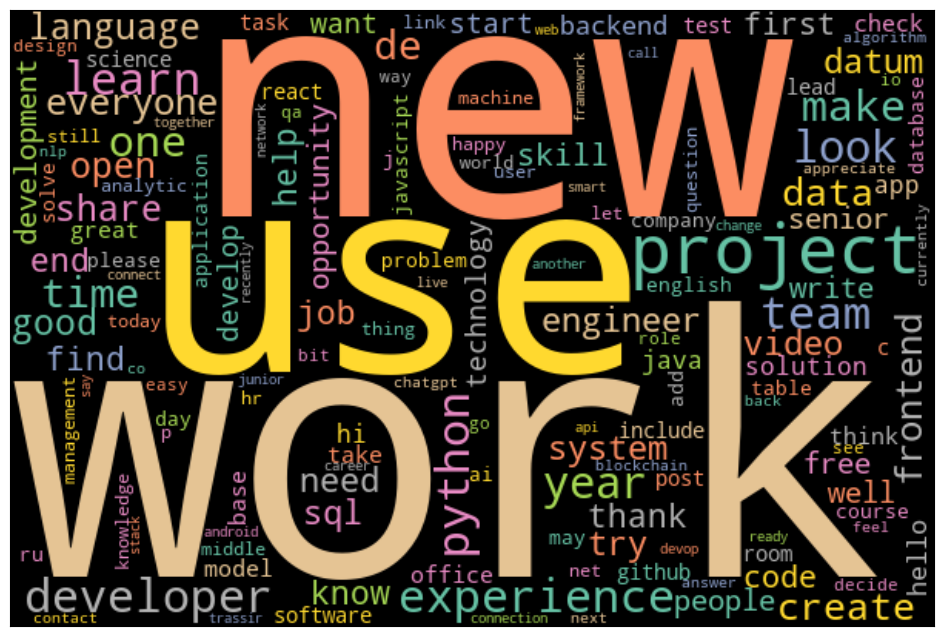

In [22]:
plt.figure(figsize=(12,8))
text = ' '.join(df['post_clean_en'])
WC = WordCloud(width=600, 
               height=400, 
               max_words=150, 
               min_font_size=5,
               colormap='Set2', 
               collocations=False)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show;

В английском реже употребляют слова компания и команда. Из-за ориентированности социальной сети на создание профессиональных контактов и как следствие поиск с помощью нее работы, самым популярным словом в обоих случаях является слово "работа".

Выделим из текстов комментариев основные темы и выведем наиболее характерные из них

In [23]:
def tag_posts(df_col, ru=True, n_topics=4, n_tag=5, min_df=0.02, max_df=0.92):
    '''
    print mostpopular tag and typical posts
    df_col --> pd.df[arr]
    ru --> True - ru, False - en
    n_topics --> num tags
    min_df --> TfidfVectorizer(min_df)
    max_df --> TfidfVectorizer(max_df)
    '''
    if ru:
        tfidf = TfidfVectorizer(stop_words=stop_words_ru, min_df=min_df, max_df=max_df)
        x = tfidf.fit_transform(df_col)
    else:
        tfidf = TfidfVectorizer(stop_words=stop_words_en, min_df=min_df, max_df=max_df)
        x = tfidf.fit_transform(df_col)

    id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=1)
    topics = lda.fit_transform(x)

    for i in range(n_topics):
        c = lda.components_[i, :]
        topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-n_tag:]]
        print("Ключевые слова",i+1, ":")
        print("#" + ", #".join(topic_tokens))

        doc_id = np.argmax(topics[:, i])
        print("Типичный пост:")
        print(df.iloc[doc_id]["post"][:120])
        print(df.iloc[doc_id]["post"][120:240]) 
        print(df.iloc[doc_id]["post"][240:350] + '...')
        print("."*50)

    # Извлечение топовых слов для каждой темы
    feature_names = tfidf.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_indices = np.argsort(topic)[::-1][:5]
        top_words.append([feature_names[i] for i in top_words_indices])

    # Создание списка со значениями тем для каждого документа
    tops = [top_words[np.argmax(distribution)] for distribution in topics]
    return tops

In [24]:
df['tags_ru'] = tag_posts(df["post_clean_ru"])
df['tags_en'] = tag_posts(df["post_clean_en"], ru=False)

# короткие фразы уберем
df.loc[df['len_post_en'] < 20, 'tags_en'] = ''
df.loc[df['len_post_ru'] < 20, 'tags_ru'] = ''

Ключевые слова 1 :
#команда, #искать, #решение, #статья, #разработчик
Типичный пост:
Приведи друга - получи рефералку 💸 У нас в STRONG появилась классная реферальная программа)  Если вы знаете кого-то, кто
 мог бы подойти к нам в команду, то мы готовы щедро вознаградить за рекомендацию. Всё, что нужно сделать:1. Рассказать с
воему другу о нашей команде2. Отправить мне его резюме и контакты 3. Если ваш друг успешно пройдет отбор и исп...
..................................................
Ключевые слова 2 :
#привет, #опыт, #поиск, #компания, #работа
Типичный пост:
Всем привет, Самокат ищет таланты!Позиция: Team Lead в группу RecSysЛокация: Москва , Санкт-Петербург, гибрид или полная
 удаленка 🌴Вилка Gross: 350-400 — год опыта Team Lead, 400-500 — год опыта Team Lead и релевантный опыт в ML.Меня зовут 
Алексей Когай, я руковожу отделом Data Science в направлении Маркетплейс. В экосистеме Самоката я строю платфо...
..................................................
Ключевые слова 3 :
#кана

In [25]:
df.sort_values('reaction', ascending=False).head(5)

,post,reaction,post_clean_ru,post_clean_en,len_post_en,len_post_ru,total_len_post,tags_ru,tags_en
1713,"Алгоритмы LinkedIn 2023 в одной инфографикеПеревел и адаптировал под русскоязычную аудиторию данные из актуального исследования по алгоритмам LinkedInДанные в этом исследовании больше относятся к тем, кто делает контент в LinkedIn, а не только бездумно спамит в личку. Есть к вам просьба: оставит...",787,алгоритм одной инфографикеперевел адаптировать русскоязычный аудитория данные актуальный исследование алгоритм данные исследование относиться делать контент бездумно спамит личка просьба поблагодарить автор контент сделать это одним предложение обязательно поделюсь результат насколько удаться за...,,0,326,326,"[это, работать, вакансия, делать, человек]",
623,"It's here – the deepest, sharpest infrared view of the universe to date: Webb's First Deep Field.Previewed by President Biden on July 11, the image shows us galaxies once invisible to us. The full set of the James Webb Space Telescope's first full-color images & data will be revealed July 12: na...",535,,deep sharp infrared view universe date nasa gov webbfirstimage,62,0,62,,"[thank, python, create, net, hi]"
1509,I started my career in Data Science back in 2016 ⏳ Here's a detailed roadmap for those starting out today! What's covered:- Python- Machine Learning- Maths for ML- ML Books- MLOps- LLMsA Thread 🧵👇 1️⃣ PythonIf you are new to programming and just getting started.There isn't a better place to lear...,505,,start career datum science back detailed roadmap start today cover engx machine learningif already program want start machine learn andrew ng machine learn specialisation test time take million check nlpnlp specialization courseraa comprehensive curriculum interested natural language processing ...,453,0,453,,"[senior, learn, team, need, frontend]"
197,"It's not core to TDD to test boundary conditions, failure modes, corner cases, &c. Those tests are essential, but they aren't necessary for the TDD process itself, which is mostly about incremental design, IMO. Start with one tiny test that verifies one tiny bit of correct behavior. Get it green...",407,,core tdd test boundary condition failure mode corner case c test essential necessary tdd process mostly incremental design imo start one tiny test verifie one tiny bit correct behavior get green building exactly enough get pass maybe return constant write another test fail test slightly large bi...,433,0,433,,"[work, project, make, engineer, year]"
319,It's (mostly) true,406,,,11,0,11,,


In [26]:
# Преобразование списков в столбцах "tags_ru" и "tags_en" в строки
df['tags_ru'] = df['tags_ru'].apply(lambda x: ', '.join(x))
df['tags_en'] = df['tags_en'].apply(lambda x: ', '.join(x))

In [27]:
# Группировка и подсчет суммы реакций для каждого уникального тега в столбце "tags_ru"
tags_ru_counts = df.groupby('tags_ru')['reaction'].sum().reset_index().sort_values('reaction', ascending=False)

# Группировка и подсчет суммы реакций для каждого уникального тега в столбце "tags_en"
tags_en_counts = df.groupby('tags_en')['reaction'].sum().reset_index().sort_values('reaction', ascending=False)

tags_ru_counts[1:].reset_index(drop=True)

,tags_ru,reaction
0,"работа, компания, поиск, опыт, привет",3541
1,"это, работать, вакансия, делать, человек",1678
2,"курс, модель, первый, свой, канал",994
3,"разработчик, статья, решение, искать, команда",442


In [28]:
tags_en_counts[1:].reset_index(drop=True)

,tags_en,reaction
0,"work, project, make, engineer, year",2393
1,"senior, learn, team, need, frontend",1920
2,"thank, python, create, net, hi",1681
3,"data, developer, ru, backend, java",669


## Вывод 
В данной работе было проведено исследование комментариев и реакций пользователей на них.

Комментарии были очищены от "спама" автоматических сообщений, генерерующихся при смене статуса пользователя(поиск работы), проверки навыков на сайте и т.д. При предварительном исследовании данных было обнаружено что пользователи из России пишут посты как на русском языке так и на английском. Соответственно было принято решение анализировать их по отдельности.

Для извлечения тем была выбрана модель из пакета `sklearn` - `LatentDirichletAllocation`. Для этого проведена очистка данных от смайлов, тегов, ссылок и т.д.
По результатам работы модели было получено топ 5 тем с пятью словами для нее Ивзлечено

Как и ожидалось, учитывая специфику социальной сети Linkedin, посты пишуться в основном про поиск работы. Слово работа самое популярное и в русских комментариях и в английских.
Пользователи редко пишут на темы заданные в данном проекте.

Одной из целей данной работы является поиск популярных тем в области менторства. За время работы над данным проектом было обнаружено всего несколько постов на данную тему - компании искали для себя ментора.

Учитывая все выводы, для поиска людей заинтересованных работать в роли наставников, рекомендуется использовать популярные группы по профессиональным интересам, в зависимости от направления (frontend, backend)